# Clasificación en scikit-learn. Entrenamiento y evaluación de un clasificador bayesiano.
En este notebook aprenderás a generar un primer clasificador en python usando *scikit-learn*. Veremos cómo entrenar un clasificador Naïve Bayes con conjuntos de datos tanto de atributos categóricos como de atributos reales. Además, entrenaremos y compararemos el resultado con otros métodos, como la Regresión Logística.

Posteriormente, se evaluarán los modelos respecto a varias métricas de evaluación en clasificación, utilizando distintos métodos como *hold-out* y *k-fold cross-validation*.

Es recomendable tener en todo momento disponible la [Guía de usuario](https://scikit-learn.org/stable/user_guide.html) o la documentación de la [API](https://scikit-learn.org/stable/modules/classes.html) de *scikit-learn*.

## 1.   Naïve Bayes con atributos categóricos

En primer lugar, vamos a entrenar un clasificador bayesiano (Naïve Bayes) utilizando un conjunto de datos donde los atributos son categóricos, es decir, cada uno puede tomar un valor de entre un conjunto de valores predefinidos. Este método es el visto en el material disponible para esta lección.

Para ello, primero cargaremos el dataset [*vote*](https://www.openml.org/d/56) disponible en la base de datos *OpenML*. Posteriormente, asignaremos en la variable ``X`` los atributos de entrada, y la variable de salida en ``y``.


In [1]:
from sklearn.datasets import fetch_openml

# Cargar datos y guardar en variables X e y
vote = fetch_openml(name='vote')
X_vote = vote.data
y_vote = vote.target

# ACTUALIZACION (03/02/2022)
# Convertimos los valores categóricos a valores numéricos para que el método pueda tratar con ellos
# Sin embargo, como se verá posteriormente, seguirá tratándolos como valores categóricos
X_vote = X_vote.replace('n', 0)
X_vote = X_vote.replace('y', 1)

print(X_vote)

    handicapped-infants water-project-cost-sharing  \
0                     0                          1   
1                     0                          1   
2                   NaN                          1   
3                     0                          1   
4                     1                          1   
..                  ...                        ...   
430                   0                          0   
431                   0                          0   
432                   0                        NaN   
433                   0                          0   
434                   0                          1   

    adoption-of-the-budget-resolution physician-fee-freeze el-salvador-aid  \
0                                   0                    1               1   
1                                   0                    1               1   
2                                   1                  NaN               1   
3                                   1  

Dado que este conjunto de datos tiene valores perdidos, y que el método Naïve Bayes que utilizaremos no es capar de lidiar con dichos conjuntos de datos, en primer lugar vamos a rellenar dichos valores perdidos.

No es el objetivo de este notebook o este curso introducir a los métodos de imputación de valores perdidos, y únicamente lo utilizaremos para poder utilizar los datos posterioremente cargados.

Para más información acerca del método de imputación utilizado: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [2]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Imputar valores perdidos para poder trabajar con el conjunto de datos
# ACTUALIZACION (03/02/2022)
# Se utiliza SimpleImputer en lugar de KNNImputer, por simplicidad; imputa el valor más frecuente en cada columna
#   (Cabe destacar que no es el método más apropiado, pero solo queremos en este caso poder ejecutar)
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(X_vote)
cols = X_vote.columns
X_vote = pd.DataFrame(imputer.transform(X_vote), columns = cols, dtype='category')

print(X_vote)
print(X_vote.dtypes)

    handicapped-infants water-project-cost-sharing  \
0                   0.0                        1.0   
1                   0.0                        1.0   
2                   0.0                        1.0   
3                   0.0                        1.0   
4                   1.0                        1.0   
..                  ...                        ...   
430                 0.0                        0.0   
431                 0.0                        0.0   
432                 0.0                        1.0   
433                 0.0                        0.0   
434                 0.0                        1.0   

    adoption-of-the-budget-resolution physician-fee-freeze el-salvador-aid  \
0                                 0.0                  1.0             1.0   
1                                 0.0                  1.0             1.0   
2                                 1.0                  0.0             1.0   
3                                 1.0  

Una vez que tenemos nuestros preparados para poder utilizarlos, en primer lugar vamos a hacer una partición en hold-out de los datos. Así, tendremos una partición de datos de entrenamiento, con la que estimaremos los parámetros del modelo, y otra partición de test, con la que lo evaluaremos.

Para ello, utilizamos la función ``train_test_split``, que recibe: los datos a particionar (podría ser un único conjunto, o varios, como en este caso las variables ``X`` y ``y``; el ratio de instancias (entre 0 y 1) que se utilizarán en el conjunto de test; y el valor para la semilla aleatoria, de modo que siempre que lo ejecutemos obtengamos el mismo resultado.

En este caso, estamos dividiendo los datos en 70% para entrenamiento y 30% para test.

In [3]:
from sklearn.model_selection import train_test_split

X_vote_train, X_vote_test, y_vote_train, y_vote_test = train_test_split(X_vote, y_vote, 
                                                                        test_size=0.3, 
                                                                        random_state=0)

print('Tamaño de los conjuntos de entrenamiento y test')
print('  Entrenamiento: ' + str(X_vote_train.shape))
print('  Test: ' + str(X_vote_test.shape))

Tamaño de los conjuntos de entrenamiento y test
  Entrenamiento: (304, 16)
  Test: (131, 16)


Una vez disponemos de los datos para entrenar nuestro modelo, vamos a entrenar un clasificador [Naïve Bayes Categórico](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html), que es el estudiado en hasta el momento, para clasificación con variables discretas o categóricas.

In [4]:
# ACTUALIZACION (03/02/2022)
# Se utiliza CategoricalNB, para tratar las variables como categóricas
#   (es decir, aunque ahora tengamos valores 0,1, los tomará como categóricos y no numéricos)
from sklearn.naive_bayes import CategoricalNB

# Creamos y entrenamos el modelo con los datos de entrenamiento
cnb = CategoricalNB()
cnb = cnb.fit(X_vote_train, y_vote_train)

Tras entrenar el modelo, podemos evaluarlo en base a diversas métricas sobre el conjunto de datos de test. En el ejemplo, calculamos el *accuracy*, *precision*, *recall*, *F1-score* (también llamado *FMeasure*), y Área bajo la curva ROC (*AUC*).

Nótese que para calcular *precision*, *recall*, y *F1-score*, hay que indicarle cuál se considera la clase positiva. En este caso hemos escogido aleatoriamente la clase *democrat* como positiva, ya que ninguna de las dos clases tiene connotaciones positivas o negativas.

Por otro lado, mientras que al resto de métricas se le pasa la predicción discreta para su cálculo, dado que el AUC solo está disponible para clasificadores probabilísticos, se le pasa la probabilidad predicha de pertenencia a la clase positiva para su cálculo.


In [5]:
from sklearn.metrics import *

# Predecir sobre datos de test. Obtenemos tanto clase predicha como probabilidades
y_vote_pred = cnb.predict(X_vote_test)
y_vote_proba = cnb.predict_proba(X_vote_test)[:, 1]
print("Patrones predichos erróneamente: %d de %d." % ((y_vote_test != y_vote_pred).sum(), 
                                                    X_vote_test.shape[0]))

# Calcular e imprimir distintas métricasde evaluación
print('Accuracy: ' + str(accuracy_score(y_vote_test, y_vote_pred)))
print('Precision: ' + str(precision_score(y_vote_test, y_vote_pred, pos_label='democrat')))
print('Recall: ' + str(recall_score(y_vote_test, y_vote_pred, pos_label='democrat')))
print('F1: ' + str(f1_score(y_vote_test, y_vote_pred, pos_label='democrat')))
print('AUC: ' + str(roc_auc_score(y_vote_test, y_vote_proba)))

Patrones predichos erróneamente: 15 de 131.
Accuracy: 0.8854961832061069
Precision: 0.9571428571428572
Recall: 0.8481012658227848
F1: 0.8993288590604026
AUC: 0.9614167478091529


## 2.   Naïve Bayes con atributos reales y comparación con otros métodos

Los modelos probabilísticos, como Naïve Bayes, nos permiten no solo asignar un clasificador a una clase dada, sino que ofrecen con qué probabilidad dicho patrón o instancia se asocia acada una de las clases.

Para hacer eso en *scikit-learn*, utilizamos la función ``predict_proba``. Como se observa, obtenemos las 3 primeras filas del dataframe con ``head`` y se la pasamos al método correspondiente, que devolverá las probabilidades para cada una de las clases.

In [6]:
# ACTUALIZACION (03/02/2022)
# Seleccionamos algunas instancias (las 3 primeras por ejemplo) del conjunto de datos
examples = X_vote_test.head(3)

# Imprimimos la probabilidad de pertenencia a cada clase según el modelo
print(cnb.predict_proba(examples))

[[9.99987236e-01 1.27639448e-05]
 [1.00000000e+00 7.56940809e-11]
 [9.99899117e-01 1.00883326e-04]]


En la siguiente celda, vamos a seguir el mismo proceso para generar un clasificador Naïve Bayes, pero sobre el dataset [*breast_cancer*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), cuyos atributos son de tipo numérico (valores reales) y no categóricos.

Dado que el método Naïve Bayes estudiado hasta el momento solo podía tratar con variables de tipo categórico, utilizamos el [Gaussian Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes). Para ello, este método asume que las distribuciones de verosimilitud siguen una distribución gaussiana, y estima los parámetros de dicha distribución.

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB

# Cargar datos y almacenar en variables X_cancer e y_cancer
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

# Partición en entrenamiento y test
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, 
                                                                                test_size=0.3, 
                                                                                random_state=0)

# Generar y entrenar Gaussian Naïve Bayes
gnb = GaussianNB().fit(X_cancer_train, y_cancer_train)

# Predecir sobre test
y_cancer_pred = gnb.predict(X_cancer_test)
y_cancer_proba = gnb.predict_proba(X_cancer_test)[:, 1]
print("Patrones predichos erróneamente: %d de %d." % ((y_cancer_test != y_cancer_pred).sum(), 
                                                    X_cancer_test.shape[0]))

# Imprimimos matriz de confusion
print('Matriz de confusión')
print(confusion_matrix(y_cancer_test, y_cancer_pred))
print()

# Calcular e imprimir distintas métricasde evaluación
print('Accuracy: ' + str(accuracy_score(y_cancer_test, y_cancer_pred)))
print('Precision: ' + str(precision_score(y_cancer_test, y_cancer_pred)))
print('Recall: ' + str(recall_score(y_cancer_test, y_cancer_pred)))
print('F1: ' + str(f1_score(y_cancer_test, y_cancer_pred)))
print('AUC: ' + str(roc_auc_score(y_cancer_test, y_cancer_proba)))



Patrones predichos erróneamente: 13 de 171.
Matriz de confusión
[[ 57   6]
 [  7 101]]

Accuracy: 0.9239766081871345
Precision: 0.9439252336448598
Recall: 0.9351851851851852
F1: 0.9395348837209302
AUC: 0.9854497354497355


Una vez implementado un método Naïve Bayes, y aprovechando que hemos estudiado otros métodos estudiados en esta misma lección, vamos a construir un modelo de [Regresión Logística](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) utilizando el mismo conjunto de datos de cáncer.

En la siguiente celda, utilizaremos los mismos conjuntos de entrenamiento y test generados antes, para que la comparación sea lo más justa posible.

Además, limitaremos el número de iteraciones del optimizador para la regresión logística a 100, aunque podríamos modificarlo para que el entrenamiento fuese más rápido (menos iteraciones) o para buscar un modelo mejor ajustado (más iteraciones).

**PREGUNTA:** Los resultados obtenidos con el modelo de regresión logística, ¿son peores o mejores que los de Gaussian Naïve Bayes?

In [8]:
from sklearn.linear_model import LogisticRegression

# Ignorar los warnings que dará la regresión logística por el límite de iteraciones
from warnings import simplefilter
simplefilter(action='ignore')

# Crear y entrenar regresión logística con datos de entrenamiento
lr = LogisticRegression(random_state=0, max_iter=100).fit(X_cancer_train, y_cancer_train)

# Predecir sobre test (Regresión logística también ofrece probabilidades como salida)
y_cancer_pred_lr = lr.predict(X_cancer_test)
y_cancer_proba_lr = lr.predict_proba(X_cancer_test)[:, 1]
print("Patrones predichos erróneamente: %d de %d." % ((y_cancer_test != y_cancer_pred_lr).sum(), 
                                                    X_cancer_test.shape[0]))

# Calcular e imprimir distintas métricasde evaluación
print('Accuracy: ' + str(accuracy_score(y_cancer_test, y_cancer_pred_lr)))
print('Precision: ' + str(precision_score(y_cancer_test, y_cancer_pred_lr)))
print('Recall: ' + str(recall_score(y_cancer_test, y_cancer_pred_lr)))
print('F1: ' + str(f1_score(y_cancer_test, y_cancer_pred_lr)))
print('AUC: ' + str(roc_auc_score(y_cancer_test, y_cancer_proba_lr)))

Patrones predichos erróneamente: 8 de 171.
Accuracy: 0.9532163742690059
Precision: 0.9807692307692307
Recall: 0.9444444444444444
F1: 0.9622641509433962
AUC: 0.9945620223398002


Por último, como prueba, vamos a entrenar un modelo de clasificación lineal. En este caso, utilizamos un estimador de parámetros basado en el método de gradiente descendente, [``SGDClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).

Además de entrenarlo con todas las características del problema, y de cara a poder visualizar la frontera de decisión de forma sencilla, también vamos a utilizar unicamente las dos primeras variables para clasificar. 

In [9]:
from sklearn.linear_model import SGDClassifier

# Crear y entrenar un clasificador lineal con datos de entrenamiento
lc = SGDClassifier(random_state=0)
lc = lc.fit(X_cancer_train, y_cancer_train)

# Predecir sobre test (en este caso, no podemos predecir probabilidades con el clasificador lineal)
y_cancer_pred_lc = lc.predict(X_cancer_test)
print("Clasificación lineal")
print("Patrones predichos erróneamente: %d de %d." % ((y_cancer_test != y_cancer_pred_lc).sum(), 
                                                    X_cancer_test.shape[0]))

# Calcular e imprimir distintas métricas de evaluación
print('Accuracy: ' + str(accuracy_score(y_cancer_test, y_cancer_pred_lc)))
print('Precision: ' + str(precision_score(y_cancer_test, y_cancer_pred_lc)))
print('Recall: ' + str(recall_score(y_cancer_test, y_cancer_pred_lc)))
print('F1: ' + str(f1_score(y_cancer_test, y_cancer_pred_lc)))

# Entrenar clasificador lineal utilizando únicamente los dos primeros atributos
lc2 = SGDClassifier(random_state=0)
lc2 = lc2.fit(X_cancer_train[:,0:2], y_cancer_train)

# Predecir sobre test
y_cancer_pred_lc2 = lc2.predict(X_cancer_test[:,0:2])
print()
print("Clasificación lineal con 2 atributos")
print("Patrones predichos erróneamente: %d de %d." % ((y_cancer_test != y_cancer_pred_lc2).sum(), 
                                                    X_cancer_test.shape[0]))

# Calcular e imprimir distintas métricasde evaluación
print('Accuracy: ' + str(accuracy_score(y_cancer_test, y_cancer_pred_lc2)))
print('Precision: ' + str(precision_score(y_cancer_test, y_cancer_pred_lc2)))
print('Recall: ' + str(recall_score(y_cancer_test, y_cancer_pred_lc2)))
print('F1: ' + str(f1_score(y_cancer_test, y_cancer_pred_lc2)))

Clasificación lineal
Patrones predichos erróneamente: 64 de 171.
Accuracy: 0.6257309941520468
Precision: 1.0
Recall: 0.4074074074074074
F1: 0.5789473684210525

Clasificación lineal con 2 atributos
Patrones predichos erróneamente: 41 de 171.
Accuracy: 0.7602339181286549
Precision: 0.7248322147651006
Recall: 1.0
F1: 0.8404669260700389


No handles with labels found to put in legend.


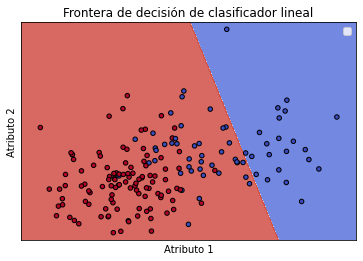

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Frontera de decisión de clasificador lineal')
# Set-up grid for plotting.
X0, X1 = X_cancer_test[:, 0], X_cancer_test[:, 1]
xx, yy = make_meshgrid(X0, X1)
y = y_cancer_test

plot_contours(ax, lc2, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Atributo 2')
ax.set_xlabel('Atributo 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

## 3.   Evaluación con validación cruzada (*cross-validation*)

Hasta el momento, hemos utilizado una partición aleatoria en *hold-out*, utilizando 70% de los datos para entrenar los modelos, y un 30% para evaluarlos. Aunque es una práctica extendida, puede llevar a comparaciones no del todo justas, más aun en casos donde los datos puedan estar muy desbalanceados, o donde el conjunto de datos sea pequeño, ya que los resultados estarán muy sesgados por los datos escogidos en para test.

Si queremos hacer una comparación aun más justa, lo ideal es utilizar un proceso de *k-folds cross-validation*, de modo que todos los patrones se utilicen una vez en el proceso de evaluación, evitando sesgar los resultados por el rendimiento en ciertos patrones concretos.

Para ello, una vez creemos los modelos, en lugar de utilizar la función ``fit``, utilizaremos ``cross_validate``, que se encargará de realizar el proceso de validación cruzada automáticamente. En el ejemplo, se generan 10 particiones (parámetro ``cv``), por lo que los resultados finales estarán promediados entre dichas 10 particiones. 

El método ``cross-validate`` también recibe una lista de métricas a calcular, en el parámetro ``scoring``. Así, la función devolverá un diccionario con los valores de cada una de esas métricas en cada una de las particiones de test. Además, devuelve otros valores: ``fit_time``, con el tiempo necesario para entrenar cada modelo; y ``score_time``, el tiempo necesario para evaluar cada modelo.

Para hacer el proceso aun más justo si cabe, debería repetirse varias veces con semillas aleatorias distintas, de modo que los resultados tampoco estén tan influenciados por las particiones generadas.

**PREGUNTA:** ¿Podrías modificar el código para que repita el proceso de 10-folds cv *n* veces, de modo que los resultados finales de las métricas sean el promedio entre todas las ejecuciones? 

**PREGUNTA:** ¿Qué modelo considerarías que es mejor, en este problema?

In [11]:
from sklearn.model_selection import cross_validate

# Ignorar los warnings que dará la regresión logística por el límite de iteraciones
from warnings import simplefilter
simplefilter(action='ignore')

# Cargar datos y almacenar en variables X_cancer e y_cancer
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

# Crear modelos (pero no entrenar)
gnb = GaussianNB()
lr = LogisticRegression(random_state=0, max_iter=100)
lc = SGDClassifier(random_state=0)

# Validación cruzada de Naive Bayes e imprimir resultados medios entre las 10 ejecuciones
print('Gaussian Naive Bayes')
cv_gnb = cross_validate(gnb, X_cancer, y_cancer, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
# Para cada valor del diccionario devuelvo, imprimir su nombre de columna o clave, y la media entre las ejecuciones
for column in cv_gnb.keys():
  print('  ' + column + ': ' + str(cv_gnb[column].mean()))

# Validación cruzada de Regresión Logística e imprimir resultados medios entre las 10 ejecuciones
print()
print('Logistic regression')
cv_lr = cross_validate(lr, X_cancer, y_cancer, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for column in cv_lr.keys():
  print('  ' + column + ': ' + str(cv_lr[column].mean()))

# Validación cruzada de Clasificación lineal e imprimir resultados medios entre las 10 ejecuciones
print()
print('SGD Linear Classification')
cv_lc = cross_validate(lc, X_cancer, y_cancer, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'])
for column in cv_lc.keys():
  print('  ' + column + ': ' + str(cv_lc[column].mean()))

Gaussian Naive Bayes
  fit_time: 0.0005226373672485351
  score_time: 0.0020673274993896484
  test_accuracy: 0.9367794486215537
  test_precision: 0.9359493493936218
  test_recall: 0.9662698412698413
  test_f1: 0.9504942719185197
  test_roc_auc: 0.9884412148697864

Logistic regression
  fit_time: 0.02673492431640625
  score_time: 0.0022507190704345705
  test_accuracy: 0.9420426065162907
  test_precision: 0.948280319750908
  test_recall: 0.9609523809523809
  test_f1: 0.9541341913838538
  test_roc_auc: 0.9914320071462928

SGD Linear Classification
  fit_time: 0.0017953157424926759
  score_time: 0.0014432907104492188
  test_accuracy: 0.875344611528822
  test_precision: 0.9390342243061941
  test_recall: 0.8663492063492063
  test_f1: 0.8941616620229496
